# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks which hide some of the computation from you. It builds on the first lab where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates. 

All the frameworks for deep learning you will meet from now on uses automatic differentiation (autodiff) so you don't have to code the backward step yourself. In this version of this lab you will develop your own autodif implementation. We also have a [version](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_NumPy/2.1-FNN-NumPy.ipynb) of this lab where you have to code the backward pass explicitly in Numpy.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation. 
2. [NumPy](https://numpy.org/). Part of Anaconda distribution. If you already know how to program most things about Python and NumPy can be found through Google search.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by Rasmus Berg Palm that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop 
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [42]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/main/nanograd.py

from math import exp, log, tanh

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])
    
    def tanhi(self):
        return Var(tanh(self.v), lambda: [(self, 1-tanh(self.v)**2)])
    
    def sigmoid_x(self, x):
        return 1/(1+exp(-x))
                  
    def sigmoid(self):
        return Var(self.sigmoid_x(self.v), lambda: [(self, self.sigmoid_x(self.v)*(1-self.sigmoid_x(self.v)))])
    
    def identity(self):
        return self
    
    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

A few examples illustrate how we can use this:

In [5]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [6]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

We calculate the value of $a*b$ and then calculate $\frac{\partial f}{\partial a}$ and $\frac{\partial f}{\partial b}$. The value of derivative of $f$ with respect to $a$ is stored as a.grad and derivative of $f$ with respect to $b$ is stored as b.grad. f.grad is equal to 1 but we do not really calculate any derivative here as we start the backprop from $f$.

#### Exercise b) How does the backward function work?

For the first example above, make a schematic of the data structure which is generated when we define the expression for f. Then execture the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables. Write down the sequence of calls to backprop for the first example above.

The data structure for $f$ is following:
$$f=a*b=Var(15.0, [(Var(3.0),5.0), (Var(5.0),3.0)])$$

Then we follow the sequence:
- call the backprop with the bp value of 1 - it is just for the implementation purpose
- call the backprop first for the $Var(3.0)$ and grad value of $5$ which is equal to $\frac{\partial f}{\partial a}=b$
- call the backprop for the $Var(5.0)$ and grad value of $3$ which is equal to $\frac{\partial f}{\partial b}=a$

Those are all of the calls to backprop in the first example

## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

In [7]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


If we run backword again we essentially call backprop again for each step and add grads to already calculated ones. The function does not have any memory to know wether we already did call the backprop or not. The state of the Var objects is not changing when we call the function apart from the grads values so we should just use it once to acquire the proper gradient values

## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

In [8]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

f.backprop(-1.0)

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)
Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


When we call the backprop function for the grad_fn elements we call it with an argument of $grad*bp$ if we set $bp$ to $-1$ we essentially do the same calculations as before but we subtract each gradient value instead of adding it. That's why doing the same number of backprop calls with the value of $1$ and $-1$ will always zero the gradient values.

## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.


_Insert your code in the cell below._


In [9]:
# test function - try to change into other functions as well
def test_function(a):
    a = Var(a)
    b = Var(5.0)
    f = a * b
    f.backward()
    return a,b,f

for v in test_function(3.0):
    print(v)

# Insert your finite difference code here
def finite_difference(a,b,da=1e-10):
    """
    This function compute the finite difference between
    
    Input:
    da:          The finite difference                           (float)
    a:          parameter                           (float)
    b:          constant                           (float)
    
    Output:
    finite_difference: numerical approximation to the derivative (float) 
    """
    
    fa_da = b*(a+da)           # <- Insert correct expression
    fa = b*a               # <- Insert correct expression

    finite_difference = (fa_da - fa) / da
    
    return finite_difference

print(finite_difference(3,5))

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
5.000000413701855


# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [11]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)    
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T
    
    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)
    
    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)
    
    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma
    
    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [12]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

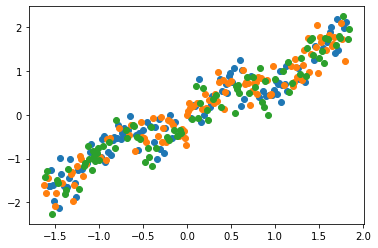

In [13]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [14]:
# convert from nparray to Var
def nparray_to_Var(x):
    if x.ndim==1:
        y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
    else:
        y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
    return y
   
x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)


In [15]:
x_train

[[Var(v=0.7213, grad=0.0000)],
 [Var(v=1.4497, grad=0.0000)],
 [Var(v=0.1316, grad=0.0000)],
 [Var(v=-1.5219, grad=0.0000)],
 [Var(v=1.0682, grad=0.0000)],
 [Var(v=0.9872, grad=0.0000)],
 [Var(v=0.6403, grad=0.0000)],
 [Var(v=-0.3656, grad=0.0000)],
 [Var(v=-1.5681, grad=0.0000)],
 [Var(v=0.3975, grad=0.0000)],
 [Var(v=1.1144, grad=0.0000)],
 [Var(v=-0.9669, grad=0.0000)],
 [Var(v=0.8947, grad=0.0000)],
 [Var(v=-1.1056, grad=0.0000)],
 [Var(v=0.4785, grad=0.0000)],
 [Var(v=0.9294, grad=0.0000)],
 [Var(v=1.7157, grad=0.0000)],
 [Var(v=0.8138, grad=0.0000)],
 [Var(v=0.0853, grad=0.0000)],
 [Var(v=0.2819, grad=0.0000)],
 [Var(v=-0.7240, grad=0.0000)],
 [Var(v=-0.3193, grad=0.0000)],
 [Var(v=1.2532, grad=0.0000)],
 [Var(v=1.2647, grad=0.0000)],
 [Var(v=-0.4234, grad=0.0000)],
 [Var(v=-1.1403, grad=0.0000)],
 [Var(v=1.6232, grad=0.0000)],
 [Var(v=1.7851, grad=0.0000)],
 [Var(v=0.1894, grad=0.0000)],
 [Var(v=1.1260, grad=0.0000)],
 [Var(v=-1.4294, grad=0.0000)],
 [Var(v=0.2703, grad=0.0000)]

# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it. 
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [16]:
class Initializer:

    def init_weights(self, n_in, n_out):
        raise NotImplementedError

    def init_bias(self, n_out):
        raise NotImplementedError

In [17]:
import random

class NormalInitializer(Initializer):

    def __init__(self, mean=0, std=0.1):
        self.mean = mean
        self.std = std

    def init_weights(self, n_in, n_out):
        return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

    def init_bias(self, n_out):
        return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

    def __init__(self, weight=1.0, bias=0.0):
        self.weight = weight
        self.bias = bias

    def init_weights(self, n_in, n_out):
        return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

    def init_bias(self, n_out):
        return [Var(self.bias) for _ in range(n_out)]

In [18]:
initializer = NormalInitializer()

In [19]:
initializer.init_weights(1, 5)

[[Var(v=0.2430, grad=0.0000),
  Var(v=-0.0757, grad=0.0000),
  Var(v=0.2353, grad=0.0000),
  Var(v=-0.0247, grad=0.0000),
  Var(v=0.0997, grad=0.0000)]]

In [20]:
initializer.init_weights(5, 1)

[[Var(v=-0.0146, grad=0.0000)],
 [Var(v=-0.1182, grad=0.0000)],
 [Var(v=0.0963, grad=0.0000)],
 [Var(v=-0.0883, grad=0.0000)],
 [Var(v=0.0728, grad=0.0000)]]

In [21]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + '\n Biases: ' + repr(self.bias)
    
    def parameters(self) -> Sequence[Var]:
        params = []
        for r in self.weights:
            params += r

        return params + self.bias

    def forward(self, inputs: Sequence[Var]) -> Sequence[Var]:
        assert len(self.weights) == len(inputs), "weights and inputs must match in first dimension"
        weights = self.weights
        out = []
        for j in range(len(weights[0])):
            node =  self.bias[j]# <- Insert code
            for i in range(len(inputs)):
                node += self.weights[i][j]*inputs[i]  # <- Insert code
            node = self.act_fn(node)
            out.append(node)

        return out

## Exercise f) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. The forward method in DenseLayer is not complete. It  just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

In [54]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

    def forward_single(x, network):
        for layer in network:
            x = layer.forward(x)
        return x

    output = [ forward_single(input[n], network) for n in range(len(input))]
    return output

print(forward(x_train[0:2], NN))


[[Var(v=-0.0009, grad=0.0000)], [Var(v=-0.0018, grad=0.0000)]]


## Exercise g) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var. 

In [23]:
# Insert code here and in the DenseLayer class
# We use __repr__ in the class and iterate over layers
layer_id = 0
for layer in NN:
    print(f'Layer {layer_id}: \n {layer} \n')
    layer_id+=1

Layer 0: 
 Weights: [[Var(v=0.0119, grad=0.0000), Var(v=-0.0329, grad=0.0000), Var(v=-0.0854, grad=0.0000), Var(v=0.0723, grad=0.0000), Var(v=0.0761, grad=0.0000)]]
 Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)] 

Layer 1: 
 Weights: [[Var(v=-0.0540, grad=0.0000)], [Var(v=-0.0228, grad=0.0000)], [Var(v=0.0279, grad=0.0000)], [Var(v=-0.0704, grad=0.0000)], [Var(v=0.0055, grad=0.0000)]]
 Biases: [Var(v=0.0000, grad=0.0000)] 



# Activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu). 
 

## Exercise h) Add more activation functions

Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

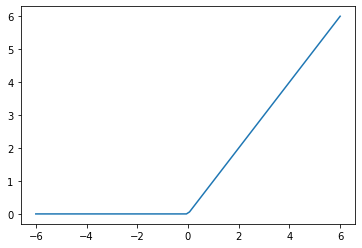

In [24]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray  
def Var_to_nparray(x):
    y = np.zeros((len(x),len(x[0])))
    for i in range(len(x)):
        for j in range(len(x[0])):
            y[i,j] = x[i][j].v
    return y

# define 1-1 network with weight = 1 and relu activation 
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ] 
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

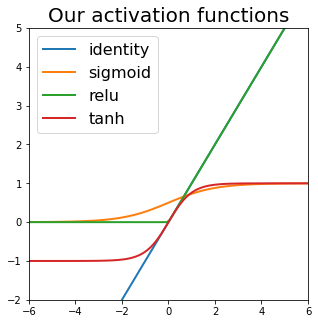

In [25]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    "sigmoid": lambda x: x.sigmoid(),  
    "relu": lambda x: x.relu(),
    "tanh": lambda x: x.tanhi() 
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf). 

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer. 

The Glorot initialization has the form: 

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).) 

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization
 
Using the Initializer class, implement functions that implement Glorot and He 

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

In [26]:
## Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
    std = 2/(n_in+n_out) # <- replace with proper initialization
    return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## He
def DenseLayer_He_relu(n_in: int, n_out: int):
    std = 2/n_in # <- replace with proper initialization
    return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions. 

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands. 

In [29]:
# Insert code here
NN = [
    DenseLayer(1, 1, lambda x: x.identity(),initializer = ConstantInitializer(1.0)),
    DenseLayer(1, 1, lambda x: x.identity(),initializer = ConstantInitializer(1.0)),
    DenseLayer(1, 1, lambda x: x.identity(),initializer = ConstantInitializer(1.0))
]

x = np.linspace(0,1,10)

In [30]:
assert x.all() == Var_to_nparray(forward(nparray_to_Var(x), NN)).all()

# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [31]:
def squared_loss(t, y):
  
    # add check that sizes agree
    assert len(t) == len(y), "t and y must match in dimension"

    def squared_loss_single(t, y):
        Loss = Var(0.0)
        for i in range(len(t)): # sum over outputs
            Loss += (t[i]-y[i]) ** 2
        return Loss

    Loss = Var(0.0)
    for n in range(len(t)): # sum over training data
        Loss += squared_loss_single(t[n],y[n])
    return Loss

## Exercise j) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i 
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'} } .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where 
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector. In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

### Answer

I think that the definition is not really suitable for our implementation. If we have to use *t* and *y* in our implementation we can't use the above definition as our implementation is returning the values already transformed by some activation function. Below I have implemented 2 functions. One of them is treating our output as a logit *h* and other as the vector of probabilities for each given class. We can see in the examples below that the loss function in terms of *p* is actually assigning small values when we are close to the correct answer while the other one still gives a big loss value.

We have 2 options: 
- Implement a softmax activation function and use it on the last layer when we want to do the classification. Then we could use the loss function in terms of probabilities. (cross_entropy_loss_y)
- Implement the function as stated in the task but then we always have to make an assumption that the function on the last layer is identity. I find it counterintuitive as we are actually including our activation function in the definition of the loss function. (cross_entropy_loss)

In [139]:
def cross_entropy_loss_y(t, y):
     
    Loss = Var(0.0)
    # Insert code here
    assert len(t) == len(y), "t and y must match in dimension"

    def ce_loss_single(t, y):
        Loss = Var(0.0)
        for i in range(len(t)): # sum over outputs
            Loss += -t[i]*y[i].log()
        return Loss

    Loss = Var(0.0)
    for n in range(len(t)): # sum over training data
        Loss += ce_loss_single(t[n],y[n])
    return Loss

In [100]:
def cross_entropy_loss(t, y):
     
    Loss = Var(0.0)
    # Insert code here
    assert len(t) == len(y), "t and y must match in dimension"

    def ce_loss_single(t, y):
        Loss_a = Var(0.0)
        Loss_b = Var(0.0)
        for i in range(len(t)): # sum over outputs
            Loss_a += -t[i]*y[i]
            Loss_b += y[i].exp()
        return Loss_a + Loss_b.log()

    Loss = Var(0.0)
    for n in range(len(t)): # sum over training data
        Loss += ce_loss_single(t[n],y[n])
    return Loss

In [123]:
t = [[Var(0.0),Var(0.0),Var(0.0),Var(1.0)], [Var(0.0),Var(0.0),Var(0.0),Var(1.0)]]
p = [[Var(0.2),Var(0.2),Var(0.3),Var(0.3)], [Var(0.01),Var(0.01),Var(0.01),Var(0.96)]]

In [124]:
cross_entropy_loss(t,p)

Var(v=2.1078, grad=0.0000)

In [125]:
cross_entropy_loss_y(t,p)

Var(v=1.2448, grad=0.0000)

In [127]:
t = [[Var(0.0),Var(0.0),Var(0.0),Var(1.0)]]
p = [[Var(0.2),Var(0.2),Var(0.3),Var(0.3)]]

In [128]:
cross_entropy_loss(t,p)

Var(v=1.3375, grad=0.0000)

In [129]:
cross_entropy_loss_y(t,p)

Var(v=1.2040, grad=0.0000)

In [130]:
t = [[Var(0.0),Var(0.0),Var(0.0),Var(1.0)]]
p = [[Var(0.01),Var(0.01),Var(0.01),Var(0.97)]]

In [131]:
cross_entropy_loss(t,p)

Var(v=0.7649, grad=0.0000)

In [132]:
cross_entropy_loss_y(t,p)

Var(v=0.0305, grad=0.0000)

# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [32]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

In [50]:
output

[[Var(v=-0.0025, grad=-1.8011)],
 [Var(v=-0.0050, grad=-3.1563)],
 [Var(v=-0.0005, grad=-1.6452)],
 [Var(v=0.0620, grad=3.3310)],
 [Var(v=-0.0037, grad=-0.6189)],
 [Var(v=-0.0034, grad=-1.1618)],
 [Var(v=-0.0022, grad=-0.7431)],
 [Var(v=0.0149, grad=0.6055)],
 [Var(v=0.0639, grad=3.3623)],
 [Var(v=-0.0014, grad=-1.0769)],
 [Var(v=-0.0038, grad=-1.4201)],
 [Var(v=0.0394, grad=1.1844)],
 [Var(v=-0.0031, grad=-0.8622)],
 [Var(v=0.0451, grad=1.7704)],
 [Var(v=-0.0016, grad=-1.7989)],
 [Var(v=-0.0032, grad=-0.9374)],
 [Var(v=-0.0059, grad=-2.9754)],
 [Var(v=-0.0028, grad=-0.8400)],
 [Var(v=-0.0003, grad=-0.3870)],
 [Var(v=-0.0010, grad=-0.8855)],
 [Var(v=0.0295, grad=0.6484)],
 [Var(v=0.0130, grad=0.1955)],
 [Var(v=-0.0043, grad=-2.1459)],
 [Var(v=-0.0043, grad=-1.6576)],
 [Var(v=0.0173, grad=0.5403)],
 [Var(v=0.0465, grad=2.3052)],
 [Var(v=-0.0056, grad=-3.8150)],
 [Var(v=-0.0061, grad=-4.0107)],
 [Var(v=-0.0006, grad=0.0176)],
 [Var(v=-0.0039, grad=-2.2395)],
 [Var(v=0.0582, grad=2.8240)]

In [45]:
y_train

[[Var(v=0.8981, grad=83.7620)],
 [Var(v=1.5732, grad=128.9800)],
 [Var(v=0.8221, grad=250.9819)],
 [Var(v=-1.6035, grad=-105.9324)],
 [Var(v=0.3058, grad=-262.0411)],
 [Var(v=0.5775, grad=-127.6820)],
 [Var(v=0.3693, grad=-103.6563)],
 [Var(v=-0.2878, grad=21.1025)],
 [Var(v=-1.6173, grad=-101.4104)],
 [Var(v=0.5371, grad=39.6578)],
 [Var(v=0.7062, grad=-115.4258)],
 [Var(v=-0.5528, grad=131.2046)],
 [Var(v=0.4280, grad=-159.0583)],
 [Var(v=-0.8402, grad=62.7656)],
 [Var(v=0.8978, grad=159.1598)],
 [Var(v=0.4655, grad=-154.7615)],
 [Var(v=1.4818, grad=9.6762)],
 [Var(v=0.4172, grad=-138.2609)],
 [Var(v=0.1932, grad=19.3280)],
 [Var(v=0.4418, grad=38.5910)],
 [Var(v=-0.2947, grad=151.4565)],
 [Var(v=-0.0847, grad=84.4931)],
 [Var(v=1.0687, grad=-12.8076)],
 [Var(v=0.8245, grad=-114.5725)],
 [Var(v=-0.2529, grad=57.7869)],
 [Var(v=-1.1061, grad=-32.4437)],
 [Var(v=1.9019, grad=207.2808)],
 [Var(v=1.9992, grad=196.1258)],
 [Var(v=-0.0094, grad=-107.9741)],
 [Var(v=1.1159, grad=45.6646)],


and the gradients will be calculated:

In [33]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 Weights: [[Var(v=-0.1310, grad=-25.6468), Var(v=-0.0294, grad=3.1515), Var(v=-0.1235, grad=-2.5725), Var(v=0.0457, grad=7.6589), Var(v=-0.0288, grad=-17.1219)]]
 Biases: [Var(v=0.0000, grad=23.3284), Var(v=0.0000, grad=-2.8666), Var(v=0.0000, grad=2.3399), Var(v=0.0000, grad=6.5785), Var(v=0.0000, grad=15.5741)]
Layer 1 
 Weights: [[Var(v=0.2562, grad=13.1146)], [Var(v=-0.0315, grad=2.9390)], [Var(v=0.0257, grad=12.3658)], [Var(v=-0.0751, grad=-4.6584)], [Var(v=0.1711, grad=2.8818)]]
 Biases: [Var(v=0.0000, grad=3.4562)]


[None, None]

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [155]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [34]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Network before update:
Layer 0 
 Weights: [[Var(v=-0.1310, grad=-25.6468), Var(v=-0.0294, grad=3.1515), Var(v=-0.1235, grad=-2.5725), Var(v=0.0457, grad=7.6589), Var(v=-0.0288, grad=-17.1219)]]
 Biases: [Var(v=0.0000, grad=23.3284), Var(v=0.0000, grad=-2.8666), Var(v=0.0000, grad=2.3399), Var(v=0.0000, grad=6.5785), Var(v=0.0000, grad=15.5741)]
Layer 1 
 Weights: [[Var(v=0.2562, grad=13.1146)], [Var(v=-0.0315, grad=2.9390)], [Var(v=0.0257, grad=12.3658)], [Var(v=-0.0751, grad=-4.6584)], [Var(v=0.1711, grad=2.8818)]]
 Biases: [Var(v=0.0000, grad=3.4562)]

Network after update:
Layer 0 
 Weights: [[Var(v=0.1254, grad=-25.6468), Var(v=-0.0609, grad=3.1515), Var(v=-0.0978, grad=-2.5725), Var(v=-0.0309, grad=7.6589), Var(v=0.1424, grad=-17.1219)]]
 Biases: [Var(v=-0.2333, grad=23.3284), Var(v=0.0287, grad=-2.8666), Var(v=-0.0234, grad=2.3399), Var(v=-0.0658, grad=6.5785), Var(v=-0.1557, grad=15.5741)]
Layer 1 
 Weights: [[Var(v=0.1251, grad=13.1146)], [Var(v=-0.0609, grad=2.9390)], [Var(v=-

[None, None]

In [35]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D: 
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [36]:
# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3 

In [37]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        


   0 ( 0.00%) Train loss: 102.210 	 Validation loss: 100.343
  10 ( 5.00%) Train loss: 24.860 	 Validation loss: 18.127
  20 (10.00%) Train loss: 15.477 	 Validation loss: 11.442
  30 (15.00%) Train loss: 14.579 	 Validation loss: 10.707
  40 (20.00%) Train loss: 13.037 	 Validation loss: 9.960
  50 (25.00%) Train loss: 12.401 	 Validation loss: 9.481
  60 (30.00%) Train loss: 12.242 	 Validation loss: 9.228
  70 (35.00%) Train loss: 12.163 	 Validation loss: 9.111
  80 (40.00%) Train loss: 12.107 	 Validation loss: 9.024
  90 (45.00%) Train loss: 12.068 	 Validation loss: 8.962
 100 (50.00%) Train loss: 12.028 	 Validation loss: 8.930
 110 (55.00%) Train loss: 11.986 	 Validation loss: 8.918
 120 (60.00%) Train loss: 11.952 	 Validation loss: 8.906
 130 (65.00%) Train loss: 11.936 	 Validation loss: 8.915
 140 (70.00%) Train loss: 11.924 	 Validation loss: 8.928
 150 (75.00%) Train loss: 11.915 	 Validation loss: 8.942
 160 (80.00%) Train loss: 11.910 	 Validation loss: 8.952
 170 (85

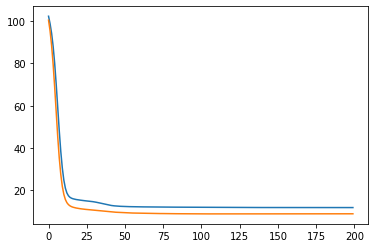

In [38]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [39]:
output_test = forward(x_test, NN)

Test loss:  9.790


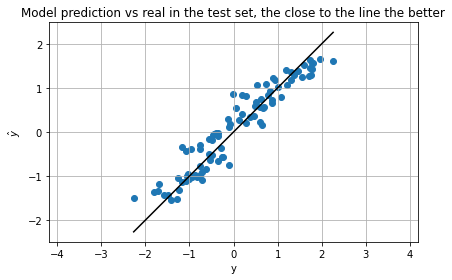

In [40]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

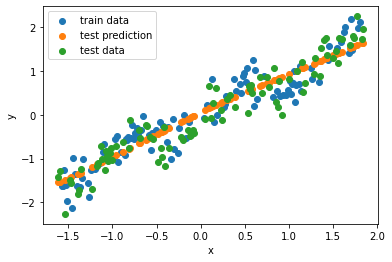

In [41]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise k) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss. 

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.

_Insert written answer here._

We don't see a big difference as in our case test and validation sets have exactly the same assumptions. It is important to keep them separate if we for example want to tune our network based on validation set. For example we check 10 different networks and check which of them has the best parameters in terms of the error on validation. then we use the test set to do the unbiased assesment of quality.

### Overfitting

To show overfitting I use a large number of epochs, a very simple network and a high learning rate. It is easier to see it on the 3D dataset. Below we can notice that after a certain amount of epochs the train loss keeps getting smaller but the distance from the validation loss stays relatively the same.

In [166]:
D1 = False
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

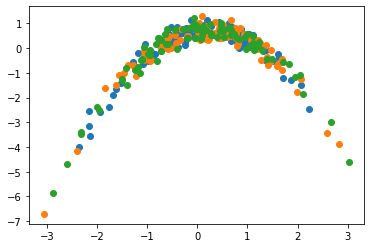

In [158]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [169]:
# convert from nparray to Var
def nparray_to_Var(x):
    if x.ndim==1:
        y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
    else:
        y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
    return y
   
x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)


In [175]:
# Insert your code for getting overfitting, underfitting and just right fitting
# Initialize an arbitrary neural network
NN = [
    DenseLayer(3, 10, lambda x: x.relu()),
    DenseLayer(10, 1, lambda x: x.identity())
]

# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 0.001

train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        


   0 ( 0.00%) Train loss: 102.203 	 Validation loss: 72.592
  10 ( 5.00%) Train loss: 86.849 	 Validation loss: 65.229
  20 (10.00%) Train loss: 66.470 	 Validation loss: 55.038
  30 (15.00%) Train loss: 49.628 	 Validation loss: 43.083
  40 (20.00%) Train loss: 35.341 	 Validation loss: 30.532
  50 (25.00%) Train loss: 22.535 	 Validation loss: 19.521
  60 (30.00%) Train loss: 14.514 	 Validation loss: 13.403
  70 (35.00%) Train loss: 10.479 	 Validation loss: 11.163
  80 (40.00%) Train loss: 8.451 	 Validation loss: 10.604
  90 (45.00%) Train loss: 7.294 	 Validation loss: 10.444
 100 (50.00%) Train loss: 6.606 	 Validation loss: 10.242
 110 (55.00%) Train loss: 6.072 	 Validation loss: 10.031
 120 (60.00%) Train loss: 5.592 	 Validation loss: 9.684
 130 (65.00%) Train loss: 5.207 	 Validation loss: 9.376
 140 (70.00%) Train loss: 4.732 	 Validation loss: 8.982
 150 (75.00%) Train loss: 4.170 	 Validation loss: 8.600
 160 (80.00%) Train loss: 3.720 	 Validation loss: 8.331
 170 (85.0

In [163]:
Loss_test = squared_loss(y_test, forward(x_test, NN))
print(Loss_test)

Var(v=69.3935, grad=0.0000)


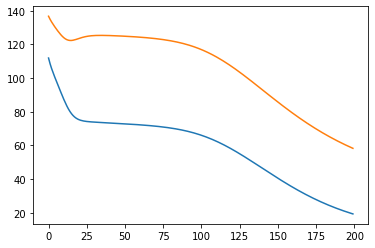

In [164]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

### Underfitting

We just put a very high learning rate and the network can't even learn the training examples.

In [171]:
# Insert your code for getting overfitting, underfitting and just right fitting
# Initialize an arbitrary neural network
NN = [
    DenseLayer(3, 10, lambda x: x.tanhi()),
    DenseLayer(10, 1, lambda x: x.identity())
]

# Initialize training hyperparameters
EPOCHS = 50
LEARN_R = 0.01

train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))

   0 ( 0.00%) Train loss: 103.920 	 Validation loss: 72.368
  10 (20.00%) Train loss: 90.427 	 Validation loss: 70.461
  20 (40.00%) Train loss: 17026958.680 	 Validation loss: 1080449414.044
  30 (60.00%) Train loss: 7008079859828297320420605952.000 	 Validation loss: 1045259027137433217425502896128.000
  40 (80.00%) Train loss: 25052454037593073317731731239539156044972017319936.000 	 Validation loss: 3736592658667779036462230721664226914236060479258624.000


### Just right fitting

We can see that by increasing our number of neurons just slightly and reducing the learning rate we keep reducing the train loss while the validation loss stays similar.

In [177]:
# Insert your code for getting overfitting, underfitting and just right fitting
# Initialize an arbitrary neural network
NN = [
    DenseLayer(3, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

# Initialize training hyperparameters
EPOCHS = 100
LEARN_R = 1e-3

train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))

   0 ( 0.00%) Train loss: 102.523 	 Validation loss: 74.768
  10 (10.00%) Train loss: 69.987 	 Validation loss: 52.930
  20 (20.00%) Train loss: 41.776 	 Validation loss: 34.673
  30 (30.00%) Train loss: 24.575 	 Validation loss: 20.792
  40 (40.00%) Train loss: 16.040 	 Validation loss: 13.597
  50 (50.00%) Train loss: 12.019 	 Validation loss: 10.581
  60 (60.00%) Train loss: 9.762 	 Validation loss: 9.322
  70 (70.00%) Train loss: 8.279 	 Validation loss: 8.774
  80 (80.00%) Train loss: 7.186 	 Validation loss: 8.473
  90 (90.00%) Train loss: 6.372 	 Validation loss: 8.256


# Next steps - classification

It is straight forward to extend what we have done to classification. 

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week. 

Next week we will see how to perform classification in PyTorch.

## Exercise l) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [ ]:
# Just add code.

## Exercise m) optional - Introduce a NeuralNetwork class

The functions we applied on the neural network (parameters, update_parameters and zero_gradients) can more naturally be included as methods in a NeuralNetwork class. Make such a class and modify the code to use it. 

In [ ]:
# just add some code